# AUTOENCODER. DATASET SENTINEL 2SR 2017-2022

## 1. Carga del archivo de datos

El autoencoder está preparado para aceptar imágenes de 128x128 pixels con 16 bandas o canales de un Tensorflow Dataset. Lo idoneo es que este dataset contenga una cantidad adecuada imagenes (mas de 1000) al menos para que pueda ver a groso modo el funcionamiento de todo el entrenamiento.

In [2]:
import tensorflow as tf
import numpy as np

def get_iter_info(iterdata):
    num_images = iterdata.cardinality().numpy()
    print("Número de imágenes en el dataset:", num_images)
    print(iterdata.element_spec)

# Cargar el dataset original
dataset = tf.data.Dataset.load('ruta/del/tensorflow/dataset', compression='GZIP')
get_iter_info(dataset)

Número de imágenes en el dataset: 3241
(TensorSpec(shape=(128, 128, 16), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


## 2. Preparación de datos

Se genera un TF Dataset donde el target es la propia imagen. En realidad este método es poco eficiente ya que duplica en memoria el tamaño del dataset original cuando se podría simplemente referenciar el propio dataset de partida para configurarlo como target.

In [4]:
# Obtener el primer tensor del conjunto de datos
def getInputs(image, label): return image

# Aplica la función `remove_labels` al conjunto de datos para eliminar las etiquetas
inputs_iter = dataset.map(getInputs)
get_iter_info(inputs_iter)

def combine_inputs_labels(inputs, labels):
    return inputs, labels

# Aplicar la función de combinación al conjunto de datos y las etiquetas
dataset_autoenc = tf.data.Dataset.zip((inputs_iter, inputs_iter))
dataset_autoenc = dataset_autoenc.map(combine_inputs_labels)
get_iter_info(dataset_autoenc)

Número de imágenes en el dataset: 3241
TensorSpec(shape=(128, 128, 16), dtype=tf.float32, name=None)
Número de imágenes en el dataset: 3241
(TensorSpec(shape=(128, 128, 16), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 16), dtype=tf.float32, name=None))


## 3. Partición entrenamiento/test

Para ver como generaliza el autoencoder con imágenes que no se han usado en el entramiento, se usan el 75% de las imágenes para entrenamiento.

In [6]:
# Definir el tamaño del conjunto de entrenamiento
num_images = dataset_autoenc.cardinality().numpy()
train_size = int(0.75 * num_images)

# Dividir el conjunto de datos en entrenamiento y prueba
train_iter = dataset_autoenc.take(train_size)
test_iter = dataset_autoenc.skip(train_size)

## 4. Definición  del modelo de autoencoder

El autoencoder trata de extraer la información de la imágen y "comprimirla" en un espacio de dimensión inferior, o lo que es lo mismo en una estructura de matrices de igual tamaño que en conjunto tengan menos datos que la imagen inicial (menor dimensión). En este caso el espacio latente esta compuesto por un vector de 256 datos (256x1x1). Las dimensión del espacio latente que resulte mas adecuada es algo que hay que descubrir probando diferentes opciones. 

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

# Definir la arquitectura del autoencoder
input_shape = (128, 128, 16)  # Dimensiones de entrada de las imágenes
latent_dim = 256  # Dimensión del espacio latente

# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
x = Dense(16 * 16 * 64, activation='relu')(encoded)  # Ajustar las dimensiones aquí
x = Reshape((16, 16, 64))(x)  # Ajustar las dimensiones aquí
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(16, (3, 3), activation='linear', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 16)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 256)     37120     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792 

## 5. Entrenamiento del modelo

Entrenamos con 5 epochs y con batches de 32 imágenes. Se usa también la librería `livelossplot` como callback para visualizar gráficamente el rendimiento del modelo durante el entrenamiento.

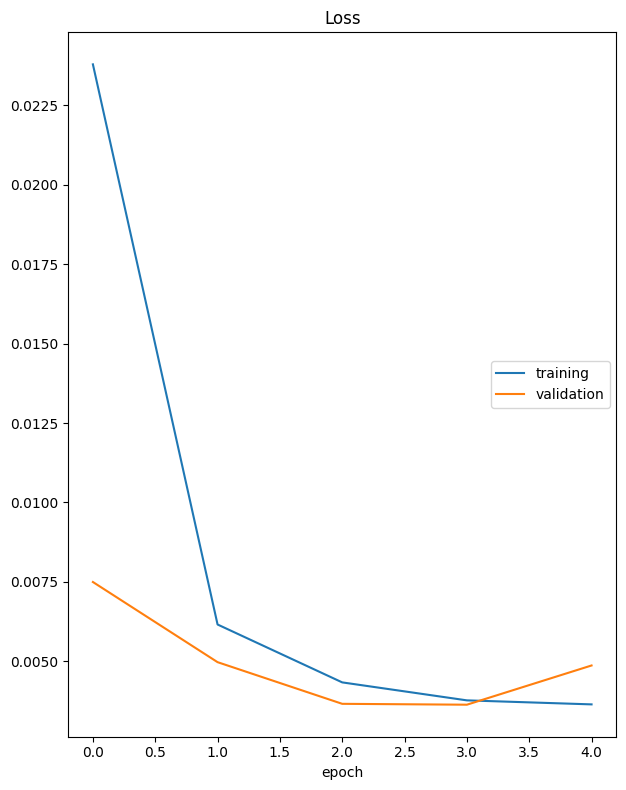

Loss
	training         	 (min:    0.004, max:    0.024, cur:    0.004)
	validation       	 (min:    0.004, max:    0.007, cur:    0.005)
76/76 [==============================] - 606s 8s/step - loss: 0.0036 - val_loss: 0.0049


In [11]:
from livelossplot import PlotLossesKerasTF

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_iter.batch(32),
                epochs=5,
                shuffle = True,
                validation_data = test_iter.batch(32),
                callbacks = [PlotLossesKerasTF()])

## 6. Predicción del modelo

Tomamos la imagen 57 del conjunto test para hacer una predicción

In [13]:
# Imagen de prueba del conjunto test
image_instance = dataset.skip(57).take(1)
get_iter_info(image_instance)
image_tensor, target_tensor = next(iter(image_instance))
image_array = image_tensor.numpy()
image_array.shape
image_array = tf.reshape(image_array, (1, 128, 128, 16))
# Predicción
image_pred = autoencoder.predict(image_array)
image_pred.shape

Número de imágenes en el dataset: 1
(TensorSpec(shape=(128, 128, 16), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
1/1 [==============================] - 0s 254ms/step


(1, 128, 128, 16)

## 7. Índice de Similitud Estructural

Se define una función que proporciona el Índice de Similitud Estrutural entre dos imágenes. Es índice mide la similitud entre distribuciones de la reflectancia en cada banda. Es una forma de evaluar cuantitativamente cuanto se parece la imagen predicha a la original.
https://en.wikipedia.org/wiki/Structural_similarity

In [14]:
import numpy as np

def structural_similarity(img1, img2):
    # Rango dinámico
    dynamic_range = np.max(img1) - np.min(img1)
    
    # Medias
    mean_img1 = np.mean(img1)
    mean_img2 = np.mean(img2)
    
    # Varianzas
    var_img1 = np.var(img1)
    var_img2 = np.var(img2)
    
    # Covarianza
    cov = np.mean((img1 - mean_img1) * (img2 - mean_img2))
    
    # Parámetros de ajuste
    k1 = 0.01
    k2 = 0.03
    
    # Fórmula SSIM
    numerator = (2 * mean_img1 * mean_img2 + k1 * dynamic_range) * (2 * cov + k2 * dynamic_range)
    denominator = (mean_img1 ** 2 + mean_img2 ** 2 + k1 * dynamic_range) * (var_img1 + var_img2 + k2 * dynamic_range)
    
    ssim = numerator / denominator
    
    return ssim


## 8. Visualización de resultados

Se visualizan las bandas de la imagen original y la bandas predichas por el autoencoder en la imagen de ejemplo. En este caso la similitud visual a nivel de los patrones que muestras las imágenes originales es escasa. Sin embargo de acuerdo a la similitud estructural, la distribución de reflectividad  es bastante similar en prácticament todas las bandas

In [22]:
import matplotlib.pyplot as plt

def plot_input_vs_predicted(input_image, predicted_image):
    fig, axs = plt.subplots(16, 2, figsize=(15, 45))
    
    for i in range(16):
        input_ax = axs[i, 0]
        input_img = input_image[0, :, :, i]
        input_min = np.amin(input_img)
        input_max = np.amax(input_img)
        input_plot = input_ax.imshow(input_img, cmap='viridis', vmin=input_min, vmax=input_max)
        input_ax.set_title(f'Canal de entrada {i+1}')
        fig.colorbar(input_plot, ax=input_ax)
        
        predicted_ax = axs[i, 1]
        predicted_img = predicted_image[0, :, :, i]
        predicted_plot = predicted_ax.imshow(predicted_img, cmap='viridis', vmin=input_min, vmax=input_max)
        ssim = structural_similarity(input_img, predicted_img)
        predicted_ax.set_title(f'Canal predicho {i+1}\nSSIM: {ssim:.4f}')
        fig.colorbar(predicted_plot, ax=predicted_ax)
        
    plt.tight_layout()
    plt.show()

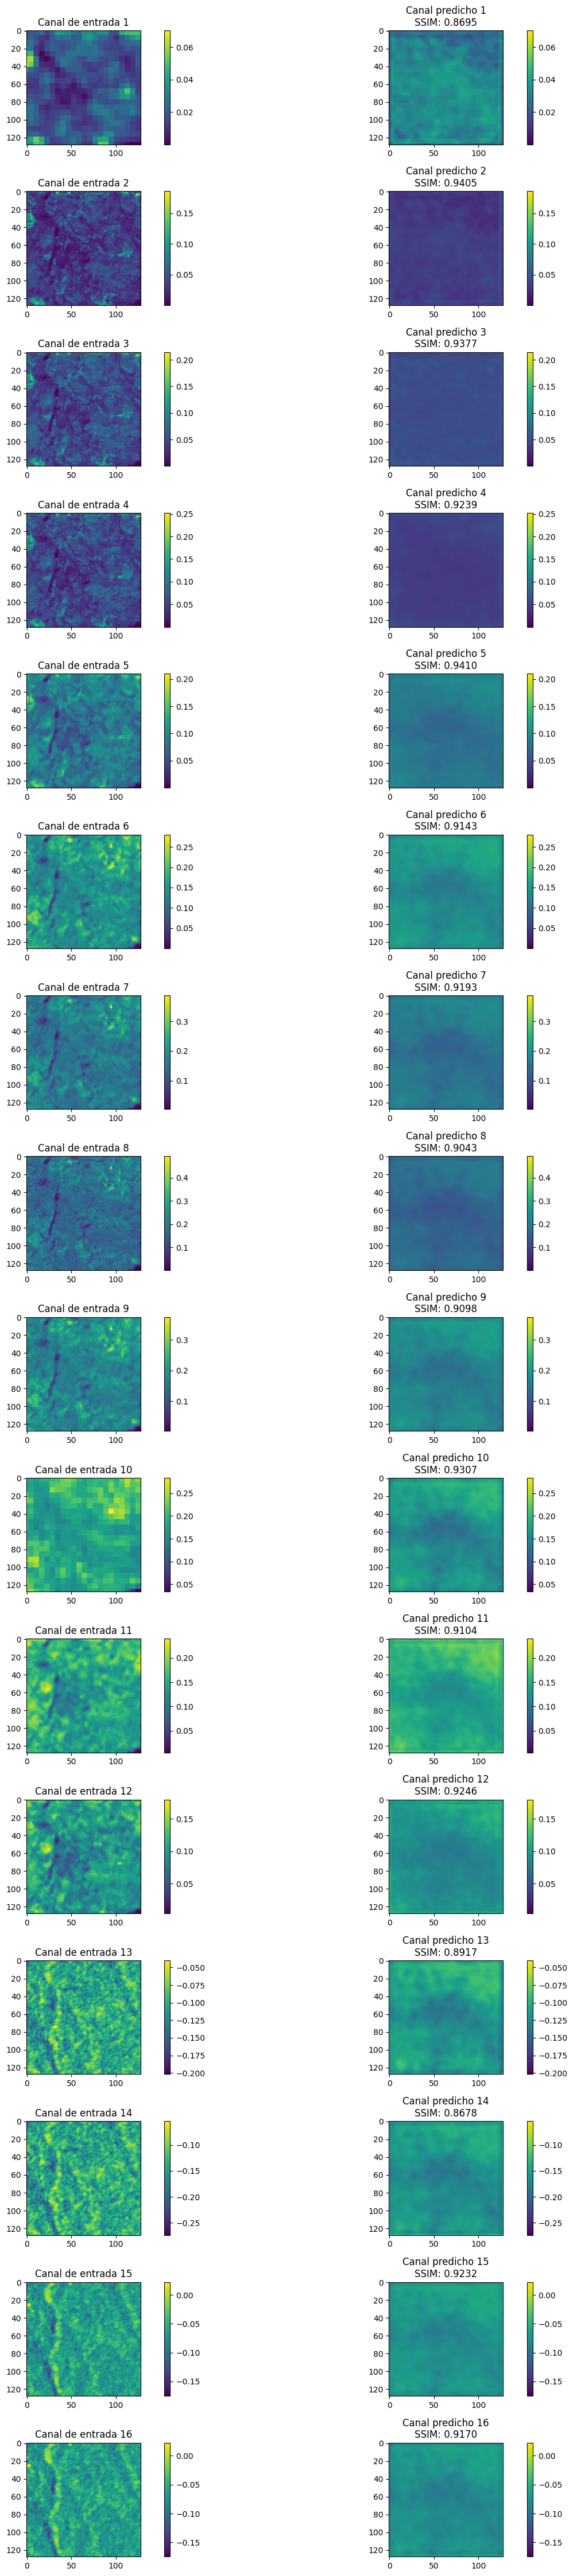

In [23]:
plot_input_vs_predicted(image_array, image_pred)